<a href="https://colab.research.google.com/github/seymadogru/BasicDataTypes/blob/master/warehouse2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import gym
from gym import spaces
import numpy as np
import time
from IPython.display import clear_output

class LogisticsEnv(gym.Env):
    def __init__(self):
        super(LogisticsEnv, self).__init__()

        self.grid_size = 20
        self.map = np.zeros((self.grid_size, self.grid_size), dtype=int)

        self.dock_pos = [0, 0]
        self._generate_map()

        # Eylemler: 0:Yukarı, 1:Aşağı, 2:Sola, 3:Sağa, 4:İşlem Yap (Al/Bırak)
        self.action_space = spaces.Discrete(5)

        # Gözlem: [Robot X, Robot Y, Taşıdığı Ürün]
        low = np.array([0, 0, 0])
        high = np.array([self.grid_size, self.grid_size, 6])
        self.observation_space = spaces.Box(low, high, dtype=np.int32)

        self.agent_pos = [0, 0]
        self.carrying = 0
        self.order_list = []
        self.max_steps = 400
        self.current_step = 0

    def _generate_map(self):
        self.map.fill(0)
        self.map[0, 0] = 2 # DOCK

        # Duvarlar
        for _ in range(30):
            x, y = np.random.randint(1, 19, 2)
            self.map[x, y] = 1

        # Raflar
        self.shelves = {
            1: [18, 18], 2: [2, 18], 3: [18, 2], 4: [10, 10], 5: [15, 5]
        }
        for k, pos in self.shelves.items():
            self.map[pos[0], pos[1]] = 10 + (k-1)

    def reset(self):
        self.agent_pos = [0, 0]
        self.carrying = 0
        self.current_step = 0
        # Rastgele 7 ürünlük uzun bir liste yapalım ki liste akışını gör
        self.order_list = list(np.random.choice([1, 2, 3, 4, 5], 7))
        return np.array([0, 0, 0])

    def step(self, action):
        self.current_step += 1
        reward = -1
        done = False

        prev_pos = self.agent_pos.copy()
        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3: self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        if self.map[self.agent_pos[0], self.agent_pos[1]] == 1:
            reward = -5
            self.agent_pos = prev_pos

        if action == 4:
            # Yük Alma
            if self.carrying == 0 and self.map[self.agent_pos[0], self.agent_pos[1]] == 2:
                if len(self.order_list) > 0:
                    self.carrying = self.order_list[0]
                    reward = 20
                else:
                    done = True
                    reward = 100

            # Yük Bırakma
            elif self.carrying > 0:
                target_shelf_val = 10 + (self.carrying - 1)
                current_cell = self.map[self.agent_pos[0], self.agent_pos[1]]

                if current_cell == target_shelf_val:
                    reward = 50
                    self.carrying = 0
                    self.order_list.pop(0) # Ürün listeden silinir
                else:
                    reward = -10
            else:
                reward = -2

        if self.current_step >= self.max_steps or len(self.order_list) == 0:
            done = True

        return np.array([self.agent_pos[0], self.agent_pos[1], self.carrying]), reward, done, {}

    def render(self):
        # --- YENİ GÖRSELLEŞTİRME KISMI ---

        # 1. Sol Panel: Liste Bilgisi
        print(f"\n--- DEPO YÖNETİM PANELİ (Adım: {self.current_step}) ---")
        print(f"📦 '{len(self.order_list)}' ürün yerleştirilmeyi bekliyor\n")
        print("BEKLEYENLER LİSTESİ:")

        if len(self.order_list) == 0:
            print("   ✅ TÜM SİPARİŞLER TAMAMLANDI!")
        else:
            # Listeyi döngüyle yazdır
            for i, item_code in enumerate(self.order_list):
                item_name = chr(64 + item_code) # 1->A, 2->B...

                # Eğer robotun elinde bir şey varsa, listenin başındaki (index 0) ürün odur.
                if i == 0 and self.carrying > 0:
                    status = f" ---> 🚚 {item_name} Ürünü - YERLEŞTİRİLİYOR..."
                else:
                    status = f"      {item_name} Ürünü"

                print(status)

        print("-" * 40)

        # 2. Harita Çizimi
        for x in range(self.grid_size):
            row = ""
            for y in range(self.grid_size):
                cell = self.map[x, y]

                # Robot
                if x == self.agent_pos[0] and y == self.agent_pos[1]:
                    if self.carrying == 0: row += "🤖"
                    else: row += "🚚"

                # Harita Elemanları
                elif cell == 1: row += "🧱"
                elif cell == 2: row += "🏭"
                elif cell == 10: row += "A"
                elif cell == 11: row += "B"
                elif cell == 12: row += "C"
                elif cell == 13: row += "D "
                elif cell == 14: row += "E "
                else: row += ". "
            print(row)

In [9]:
env = LogisticsEnv()
q_table = {}

alpha = 0.1
gamma = 0.95      # Gelecek ödülü (geri dönüşü hesaplaması için yüksek tuttum)
epsilon = 1.0
epsilon_decay = 0.9992 # Yavaş yavaş azaltsın, iyice öğrensin
min_epsilon = 0.01

def get_state_key(obs):
    return tuple(obs)

print("Eğitim Başlıyor (Bu işlem 20x20 harita için biraz sürecek)...")

episodes = 15000 # Daha fazla tekrar
for episode in range(episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
            action = np.argmax(q_table[state])

        next_obs, reward, done, _ = env.step(action)
        next_state = get_state_key(next_obs)

        if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table: q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state

    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 1000 == 0:
        print(f"Episode: {episode} tamamlandı. Epsilon: {epsilon:.3f}")

print("Eğitim Bitti!")

Eğitim Başlıyor (Bu işlem 20x20 harita için biraz sürecek)...
Episode: 0 tamamlandı. Epsilon: 0.999
Episode: 1000 tamamlandı. Epsilon: 0.449
Episode: 2000 tamamlandı. Epsilon: 0.202
Episode: 3000 tamamlandı. Epsilon: 0.091
Episode: 4000 tamamlandı. Epsilon: 0.041
Episode: 5000 tamamlandı. Epsilon: 0.018
Episode: 6000 tamamlandı. Epsilon: 0.010
Episode: 7000 tamamlandı. Epsilon: 0.010
Episode: 8000 tamamlandı. Epsilon: 0.010
Episode: 9000 tamamlandı. Epsilon: 0.010
Episode: 10000 tamamlandı. Epsilon: 0.010
Episode: 11000 tamamlandı. Epsilon: 0.010
Episode: 12000 tamamlandı. Epsilon: 0.010
Episode: 13000 tamamlandı. Epsilon: 0.010
Episode: 14000 tamamlandı. Epsilon: 0.010
Eğitim Bitti!


In [12]:
obs = env.reset()
state = get_state_key(obs)
done = False
total_reward = 0

print("Lojistik Operasyonu Başlıyor...")
time.sleep(2)

while not done:
    clear_output(wait=True)
    env.render()

    if state in q_table:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)
    state = get_state_key(obs)
    total_reward += reward

    time.sleep(0.2) # İzleme hızı

clear_output(wait=True)
env.render()
print(f"\nOperasyon Tamamlandı! Toplam Puan: {total_reward}")


--- DEPO YÖNETİM PANELİ (Adım: 274) ---
📦 '0' ürün yerleştirilmeyi bekliyor

BEKLEYENLER LİSTESİ:
   ✅ TÜM SİPARİŞLER TAMAMLANDI!
----------------------------------------
🏭. . . . . . . . . . . . . . . . . . . 
. . . . . . . . 🧱🧱. . . . . . . . . . 
. . . . . . . . . . . . . . . . . . B. 
. . . . . . . . . . . . . . . . . 🧱. . 
. . . . 🧱. . . . . . . . . . . . . 🧱. 
. . . . . . . . . . . . . . . . . . . . 
. 🧱. . . . . 🧱. 🧱. . . . 🧱. . . 🧱. 
. . . . . . . . . 🧱. . . . . . . . . . 
. . . 🧱. . . . . . . . . . . . . . 🧱. 
. . . . . 🧱🧱. . . . . . . . . . . . . 
. . . . . . . . . . D . . . . . . . . . 
. . . . . . . . . . . . . . . . . . 🧱. 
. . . . . . . . . . . 🧱. . 🧱. . 🧱. . 
. . . . . . . . 🧱. 🧱. . . . . . . . . 
. . . . 🧱. . . 🧱. . . . . . 🧱. . . . 
. . . . . 🤖. . . . . . . . . . . . . . 
. . . 🧱. 🧱. . . . . . . . . . . 🧱. . 
. . . 🧱. . . . . . . . . . . . . . . . 
. . C. . . . . . . 🧱. . . . . . . A. 
. . . . . . . . . . . . . . . . . . . . 

Operasyon Tamamlandı! Toplam Puan: 230


Performans Analizi Yapılıyor... (Robot vs Matematik)

--- SONUÇ RAPORU ---
Ortalama İdeal Adım (BFS): 45.8
Ortalama Ajan Adımı (RL):  47.8
Yol Verimliliği: %95.81
✅ MÜKEMMEL! Robot neredeyse her seferinde en kısa yolu kullanıyor.


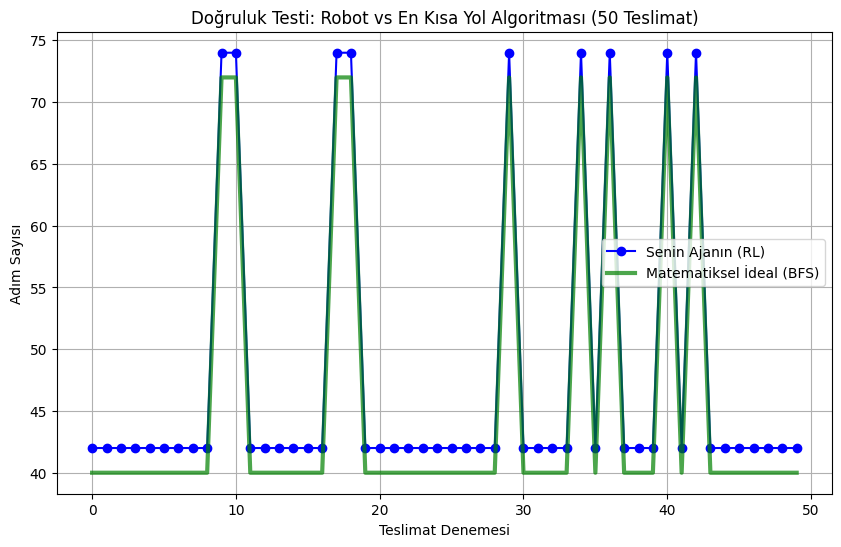

In [11]:
import matplotlib.pyplot as plt
from collections import deque

# --- 1. REFERANS ALGORİTMA (BFS - En Kısa Yol Bulucu) ---
def get_shortest_path_bfs(grid_map, start, target_val):
    """
    Duvarlardan kaçarak hedefe giden en kısa mesafeyi hesaplar.
    Bu algoritma matematiksel olarak en kısa yolu garanti eder.
    """
    rows, cols = grid_map.shape
    queue = deque([(start, 0)]) # (koordinat, mesafe)
    visited = set()
    visited.add(tuple(start))

    # Hedef koordinatlarını bul (Target value haritada nerede?)
    # Not: Target value rafların ID'si (10, 11, 12 vs.) veya Dock (2)
    target_coords = []
    for r in range(rows):
        for c in range(cols):
            if grid_map[r, c] == target_val:
                target_coords.append((r, c))

    while queue:
        (r, c), dist = queue.popleft()

        # Hedefe ulaştık mı?
        for tr, tc in target_coords:
            if r == tr and c == tc:
                return dist

        # Komşulara bak (Yukarı, Aşağı, Sol, Sağ)
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc

            if 0 <= nr < rows and 0 <= nc < cols:
                # Duvar (1) değilse ve daha önce gelmediysek
                if grid_map[nr, nc] != 1 and (nr, nc) not in visited:
                    visited.add((nr, nc))
                    queue.append(((nr, nc), dist + 1))
    return 999 # Yol yoksa (Hata durumu)

# --- 2. TEST DÖNGÜSÜ ---
print("Performans Analizi Yapılıyor... (Robot vs Matematik)")
test_episodes = 50
agent_steps_history = []
optimal_steps_history = []

for i in range(test_episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False

    current_agent_steps = 0
    current_optimal_steps = 0

    # Senaryo analizi için
    start_pos = env.agent_pos.copy()

    # 1. Aşama: Dock -> Raf (Gidiş Yolu)
    target_item = env.order_list[0]
    target_shelf_val = 10 + (target_item - 1)

    # İdeal mesafeyi hesapla (BFS)
    dist_go = get_shortest_path_bfs(env.map, start_pos, target_shelf_val)
    # 2. Aşama: Raf -> Dock (Dönüş Yolu)
    # Rafın konumunu bulup oradan Dock(2)'a mesafeyi ölçüyoruz
    # Basitlik için sadece gidiş+dönüş toplam mesafesini yaklaşık ideal alacağız
    dist_return = dist_go # Genelde gidiş dönüş aynıdır (tek yönlü yol yoksa)

    total_ideal_steps = dist_go + dist_return

    # Ajanı çalıştır
    while not done:
        if state in q_table:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()

        obs, reward, done, _ = env.step(action)
        state = get_state_key(obs)
        current_agent_steps += 1

        # Eğer bir teslimat yapıldıysa (döngü tamamlandıysa)
        # Bu test kodu sadece İLK teslimatı ölçüp dursun, grafiği karıştırmasın.
        if env.carrying == 0 and current_agent_steps > 5 and obs[0]==0 and obs[1]==0:
            break

    agent_steps_history.append(current_agent_steps)
    optimal_steps_history.append(total_ideal_steps)

# --- 3. GRAFİKSEL KANIT ---
plt.figure(figsize=(10, 6))
plt.plot(agent_steps_history, label='Senin Ajanın (RL)', color='blue', marker='o', linestyle='-')
plt.plot(optimal_steps_history, label='Matematiksel İdeal (BFS)', color='green', linewidth=3, alpha=0.7)

plt.title(f"Doğruluk Testi: Robot vs En Kısa Yol Algoritması ({test_episodes} Teslimat)")
plt.xlabel("Teslimat Denemesi")
plt.ylabel("Adım Sayısı")
plt.legend()
plt.grid(True)

# Verimlilik Hesabı
avg_agent = np.mean(agent_steps_history)
avg_opt = np.mean(optimal_steps_history)
efficiency = (avg_opt / avg_agent) * 100

print(f"\n--- SONUÇ RAPORU ---")
print(f"Ortalama İdeal Adım (BFS): {avg_opt:.1f}")
print(f"Ortalama Ajan Adımı (RL):  {avg_agent:.1f}")
print(f"Yol Verimliliği: %{efficiency:.2f}")

if efficiency > 90:
    print("✅ MÜKEMMEL! Robot neredeyse her seferinde en kısa yolu kullanıyor.")
elif efficiency > 70:
    print("⚠️ İYİ AMA GELİŞTİRİLEBİLİR. Bazen yolu uzatıyor.")
else:
    print("❌ KÖTÜ. Robot yolu buluyor ama çok dolaşıyor (Hala öğrenmesi lazım).")

plt.show()